In [2]:
import sys
assert sys.version_info >= (3, 5)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import stack
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from google.colab import drive
import seaborn as sns; sns.set()

In [3]:
#Import data
drive.mount('/content/gdrive')
df = pd.read_csv("gdrive/My Drive/diabetes.csv")

Mounted at /content/gdrive


In [4]:
#See the first 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
#Lets analyse the shape of the dataframe
df.shape

(768, 9)

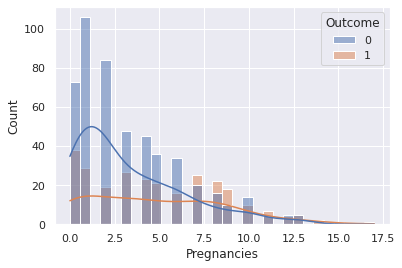

In [ ]:
#A few histograms to see how the features interact with the label
sns.histplot(data=df, x='Pregnancies', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

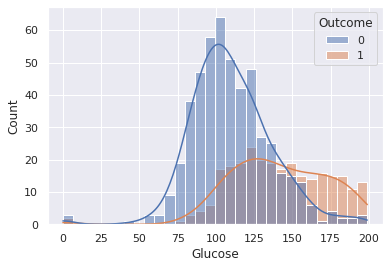

In [ ]:
sns.histplot(data=df, x='Glucose', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

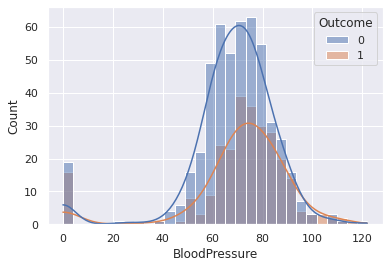

In [ ]:
sns.histplot(data=df, x='BloodPressure', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

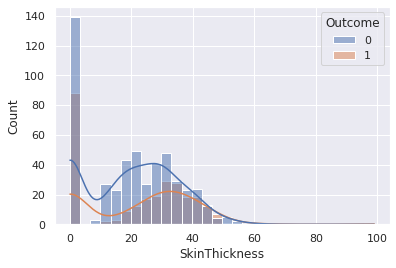

In [ ]:
sns.histplot(data=df, x='SkinThickness', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

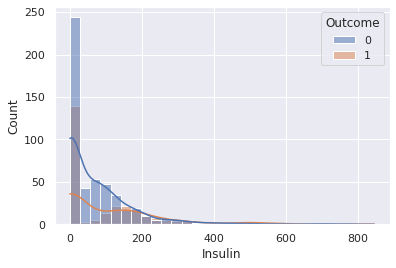

In [ ]:
sns.histplot(data=df, x='Insulin', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

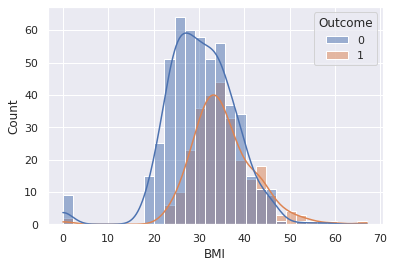

In [ ]:
sns.histplot(data=df, x='BMI', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

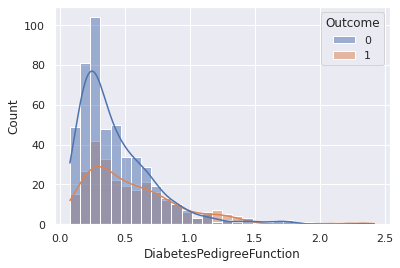

In [ ]:
sns.histplot(data=df, x='DiabetesPedigreeFunction', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

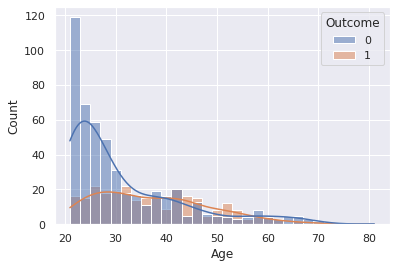

In [ ]:
sns.histplot(data=df, x='Age', hue ='Outcome', multiple='layer', bins=30, kde=True, edgecolor=None)

In [5]:
#Let's separate the features from the labels
X_array = df.loc[:, df.columns != "Outcome"]
y_array = df[["Outcome"]]

In [6]:
#Now we create the train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array,
                                                    test_size=0.2,
                                                    stratify=y_array,
                                                    random_state=0)

In [7]:
#Let's see the shape of the training set
X_train.shape

(614, 8)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#Reset index before applying standardisation
X_train.reset_index(drop=True, inplace=True);
X_test.reset_index(drop=True, inplace=True);
y_train.reset_index(drop=True, inplace=True);
y_test.reset_index(drop=True, inplace=True);

#Fit a standard scaler
scaler.fit(X_train)
scaler.fit(X_test)

#Apply transform to X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



In [ ]:
#Preparing training data by converting to tensors
X_train = np.array(X_train)
X_train_tensor = torch.tensor(X_train)
X_train_tensor = X_train_tensor.float()
y_train = np.array(y_train)
y_train_tensor = torch.tensor(y_train)
y_train_tensor = y_train_tensor.float()
y_train_tensor.shape


torch.Size([614, 1])

In [ ]:
#This will come in handy when using dataloader
train_data = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))

In [ ]:
#Preparing test data
X_test = np.array(X_test)
X_test_tensor = torch.tensor(X_test)
X_test_tensor = X_test_tensor.float()
y_test = np.array(y_test)
y_test_tensor = torch.tensor(y_test)
y_test_tensor = y_test_tensor.float()

In [ ]:
#Probably won't need this but it's good to have
test_data = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

#Defining the neural network
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.layer1 = nn.Linear(8,900)
    self.layer3 = nn.Linear(900,900)
    self.layer2 = nn.ReLU()
    self.layer4 = nn.Linear(900,2)
     
  def forward(self, x):
    x = self.layer1(x)
    x = F.relu(self.layer2(x)) 
    x = self.layer3(x)
    x = F.relu(self.layer4(x))  
    return x

#Let's see what it's doing
model = MyModel()
print(model)

#Give the option for CPU or GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#Using GPU or CPU
model.to(device)
print(model.layer1.bias.get_device())

MyModel(
  (layer1): Linear(in_features=8, out_features=900, bias=True)
  (layer2): ReLU()
  (layer3): Linear(in_features=900, out_features=900, bias=True)
  (layer4): Linear(in_features=900, out_features=2, bias=True)
)
cpu
-1


In [ ]:
#Fit model and see the shape
prediction = model(X_train_tensor)
prediction.shape

torch.Size([614, 2])

In [ ]:
#Create dataloaders for training
from torch.utils.data import Dataset, DataLoader
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=614,
                                          shuffle=True)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=614,
                                         shuffle=True)

In [ ]:
import torch.optim as optim
#Optimiser
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
#Mean Squared Error for loss criterion
criterion = nn.MSELoss()
#Number of epochs
epochs = 10000
#Empty array for storing loss values
loss_values = []

#Let's start training!
for epoch in range(epochs):
    for i, data in enumerate(train_dataloader, 0):
      inputs, labels = data
      optimizer.zero_grad()
      prediction = model(inputs.float())
      loss = criterion(prediction, labels.float())
      loss_values.append(loss.item())
      loss.backward()
      optimizer.step()
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([614, 1])) that is different to the input size (torch.Size([614, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished Training


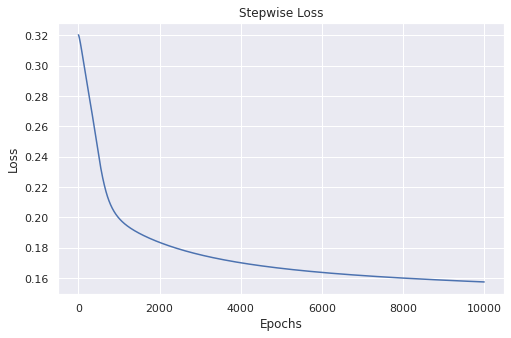

In [ ]:
#Plot the stepwise loss
step = np.linspace(0, 10000, 10000)

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(step, np.array(loss_values))
plt.title("Stepwise Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
#Preparation for Confusion Matrix
predictions = []
with torch.no_grad():
    for i,data in enumerate(X_test_tensor):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())

Text(30.5, 0.5, 'Predicted')

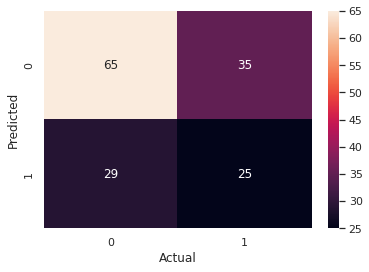

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predictions)
cm
sns.heatmap(cm,annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [ ]:
from sklearn.metrics import accuracy_score
#Accuracy of the model
score = accuracy_score(y_test, predictions)
print(score)

0.5844155844155844
